this notebook analysies data MS Dial files with a peak being defined as

"found in 100 % of samples within a sample group"

normalized and raw data.

In [1]:
import os, pandas, seaborn, numpy

In [2]:
import sklearn, sklearn.preprocessing, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

# 0. user-defined variables

In [4]:
normalized_input_file = '/home/adrian/projects/vigur/data/lipidomics/lipidomics_2023.05.26b/Normalized_8_202352685.txt'
metadata_file = '/home/adrian/projects/vigur/data/lipidomics/lipidomics_2023.05.26b/EC-008 Sample ID dataframe_16032022.xlsx'

# 1. read information

## 1.1. read data

In [22]:
intensities = pandas.read_csv(normalized_input_file, sep='\t', skiprows=4)
intensities.loc[:, '008-30 24   CAT']

0      0
1      0
2      0
3      0
4      0
      ..
290    0
291    0
292    0
293    0
294    0
Name: 008-30 24   CAT, Length: 295, dtype: int64

In [31]:
numpy.max(intensities.iloc[:, 80:-10])

/home/adrian/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


008-27 24                    1.069040e+05
008-35 4                     1.243378e+05
008-24 4 CAT                 1.620748e+04
008-42 24                    6.828784e+05
Solvent Blank_pos BLANK.2    0.000000e+00
Pool2_pos Pool.1             3.410316e+05
Solvent Blank_pos BLANK.3    0.000000e+00
008-45 24   CAT              7.763721e+05
008-39 4 CAT                 6.639103e+05
008-28 24   CAT              6.920741e+05
008-31 0                     0.000000e+00
008-26 24                    9.035490e+05
008-34 4                     0.000000e+00
Solvent Blank_pos BLANK.4    0.000000e+00
Pool2_pos Pool.2             3.410316e+05
Solvent Blank_pos BLANK.5    0.000000e+00
008-29 24   CAT              1.458654e+05
008-38 4 CAT                 0.000000e+00
008-33 0                     0.000000e+00
008-41 24                    3.775376e+05
008-32 0                     5.680162e+05
Solvent Blank_pos BLANK.6    0.000000e+00
Pool2_pos Pool.3             3.410316e+05
Solvent Blank_pos BLANK.7    0.000

# 1.2. read metadata

In [6]:
# read biological replicate
metadata = pandas.read_excel(metadata_file, sheet_name='Sampledata_POS_Combine')
metadata.head()

,Sample,Label,Sample ID,BioReplicate,Timepoint,µM catech,TecRep,TNFalpha,LPS,cell number,LCMS Method,LCMS Analytical Order,LCMS BATCH
0,PMUEC_INTRA_EC008_103,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,1,1
1,PMUEC_INTRA_EC008_104,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,2,1
2,PMUEC_INTRA_EC008_105,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,3,1
3,PMUEC_INTRA_EC008_107,Pool2_pos,Pool2_pos,-,-,-,-,-,-,-,HILIC_POS_10min,4,1
4,PMUEC_INTRA_EC008_109,008-02_pos,008-2,1,0,0,2,0,0,80000,HILIC_POS_10min,5,1


# 2. process data

In [7]:
# select the samples we need only
selected_columns = []; pools = []

for columnID in intensities.columns:
    if '008' in columnID:
        selected_columns.append(columnID)
    if 'lipids' in columnID and 'Pool.' in columnID:
        selected_columns.append(columnID); pools.append(columnID)
    if 'Pool2_pos' in columnID and 'Pool.' in columnID:
        selected_columns.append(columnID); pools.append(columnID)

selected_columns.sort(); pools.sort()
print(len(selected_columns), selected_columns)
print(len(pools), pools)

53 ['008-01 0', '008-02 0', '008-03 0', '008-04 4', '008-05 4', '008-06 4', '008-07 4 CAT', '008-08 4 CAT', '008-09 4 CAT', '008-10 24', '008-11 24', '008-12 24', '008-13 24   CAT', '008-14 24   CAT', '008-15 24   CAT', '008-16 0', '008-17 0', '008-18 0', '008-19 4', '008-20 4', '008-21 4', '008-22 4 CAT', '008-23 4 CAT', '008-24 4 CAT', '008-25 24', '008-26 24', '008-27 24', '008-28 24   CAT', '008-29 24   CAT', '008-30 24   CAT', '008-31 0', '008-32 0', '008-33 0', '008-34 4', '008-35 4', '008-36 4', '008-37 4 CAT', '008-38 4 CAT', '008-39 4 CAT', '008-40 24', '008-41 24', '008-42 24', '008-43 24   CAT', '008-44 24   CAT', '008-45 24   CAT', 'Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_pos Pool.3', 'Pool2_pos Pool.4']
8 ['Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_po

In [8]:
selected_columns = ['Average Rt(min)'] + selected_columns
selected_columns = ['Average Mz'] + selected_columns

print(len(selected_columns), selected_columns)

55 ['Average Mz', 'Average Rt(min)', '008-01 0', '008-02 0', '008-03 0', '008-04 4', '008-05 4', '008-06 4', '008-07 4 CAT', '008-08 4 CAT', '008-09 4 CAT', '008-10 24', '008-11 24', '008-12 24', '008-13 24   CAT', '008-14 24   CAT', '008-15 24   CAT', '008-16 0', '008-17 0', '008-18 0', '008-19 4', '008-20 4', '008-21 4', '008-22 4 CAT', '008-23 4 CAT', '008-24 4 CAT', '008-25 24', '008-26 24', '008-27 24', '008-28 24   CAT', '008-29 24   CAT', '008-30 24   CAT', '008-31 0', '008-32 0', '008-33 0', '008-34 4', '008-35 4', '008-36 4', '008-37 4 CAT', '008-38 4 CAT', '008-39 4 CAT', '008-40 24', '008-41 24', '008-42 24', '008-43 24   CAT', '008-44 24   CAT', '008-45 24   CAT', 'Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_pos Pool.3', 'Pool2_pos Pool.4']


In [9]:
intensities = intensities[selected_columns]
print(intensities.shape)
intensities.head()

(295, 55)


,Average Mz,Average Rt(min),008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
0,163.11206,7.633,2953.197,8087.303,18830.800,7190.9680,1876.422,2499.4700,12367.000,5073.157,...,0,5200.8660,3138.7640,3138.7640,3138.7640,3138.7640,3138.7640,3138.7640,3138.7640,3138.7640
1,171.13664,1.085,2041.548,1884.410,5090.458,578.1953,2562.610,449.1427,3811.130,1801.161,...,0,1294.9750,803.5971,803.5971,803.5971,803.5971,803.5971,803.5971,803.5971,803.5971
2,172.95811,0.838,0.000,0.000,0.000,0.0000,0.000,581.5574,7299.883,2384.220,...,0,702.9562,706.1611,706.1611,706.1611,706.1611,706.1611,706.1611,706.1611,706.1611
3,186.06477,14.434,5234.950,16004.510,27364.190,9955.4700,3281.499,4967.5480,25527.290,7732.297,...,0,20684.6600,8204.5490,8204.5490,8204.5490,8204.5490,8204.5490,8204.5490,8204.5490,8204.5490
4,205.12076,7.633,3422.109,10753.500,9132.793,4102.4450,2283.125,3079.7740,20913.080,4507.043,...,0,9588.1150,5987.4650,5987.4650,5987.4650,5987.4650,5987.4640,5987.4640,5987.4640,5987.4640


In [10]:
# merge mz and RT as unique identifier
intensities.loc[:, 'unique_ID'] = intensities.loc[:, 'Average Rt(min)'].astype(str) + '_' + intensities.loc[:, 'Average Mz'].astype(str)
intensities.drop(['Average Mz', 'Average Rt(min)'], axis='columns', inplace=True)
intensities.set_index('unique_ID', inplace=True)
intensities.sort_index(inplace=True)

print(intensities.shape)
intensities.head()

(295, 53)


,008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,008-09 4 CAT,008-10 24,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,,,,,,,,,,,,,,
0.609_305.16281,5753.669,3697.191,22702.57,599.5139,3607.243,506.6090,2263.773,2577.188,0.000,479.8244,...,0,5997.062,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566
0.611_217.10544,1955.591,9082.704,12724.20,1597.8260,3100.897,822.6395,5550.647,4295.344,2799.277,792.6133,...,0,4181.456,3834.273,3834.273,3834.273,3834.273,3834.274,3834.274,3834.274,3834.274
0.611_349.19458,5001.026,2761.085,15711.08,0.0000,3588.750,409.8544,1974.891,2045.836,0.000,356.3460,...,0,8806.825,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205
0.611_393.20673,0.000,0.000,0.00,0.0000,0.000,353.9790,0.000,2015.576,0.000,0.0000,...,0,9590.310,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457
0.612_261.13141,4057.164,5519.788,22829.36,861.8231,2857.862,523.8853,2765.267,2772.197,1166.192,564.6547,...,0,3453.685,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307


In [11]:
pool_df = intensities[pools]
pool_df.head()

,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,
0.609_305.16281,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566,5325.566
0.611_217.10544,3834.273,3834.273,3834.273,3834.273,3834.274,3834.274,3834.274,3834.274
0.611_349.19458,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205,4395.205
0.611_393.20673,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457,4200.457
0.612_261.13141,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307,3984.307


In [12]:
print(numpy.max(pool_df.iloc[:, 0] - pool_df.iloc[:, 0]))
print(numpy.max(pool_df.iloc[:, 0] - pool_df.iloc[:, -1]))

0.0
13616.05


In [13]:
log10_intensities = numpy.log10(intensities + 1)
log10_pools = numpy.log10(pool_df + 1)

# 3. visualize data

## 3.1. visualize pools

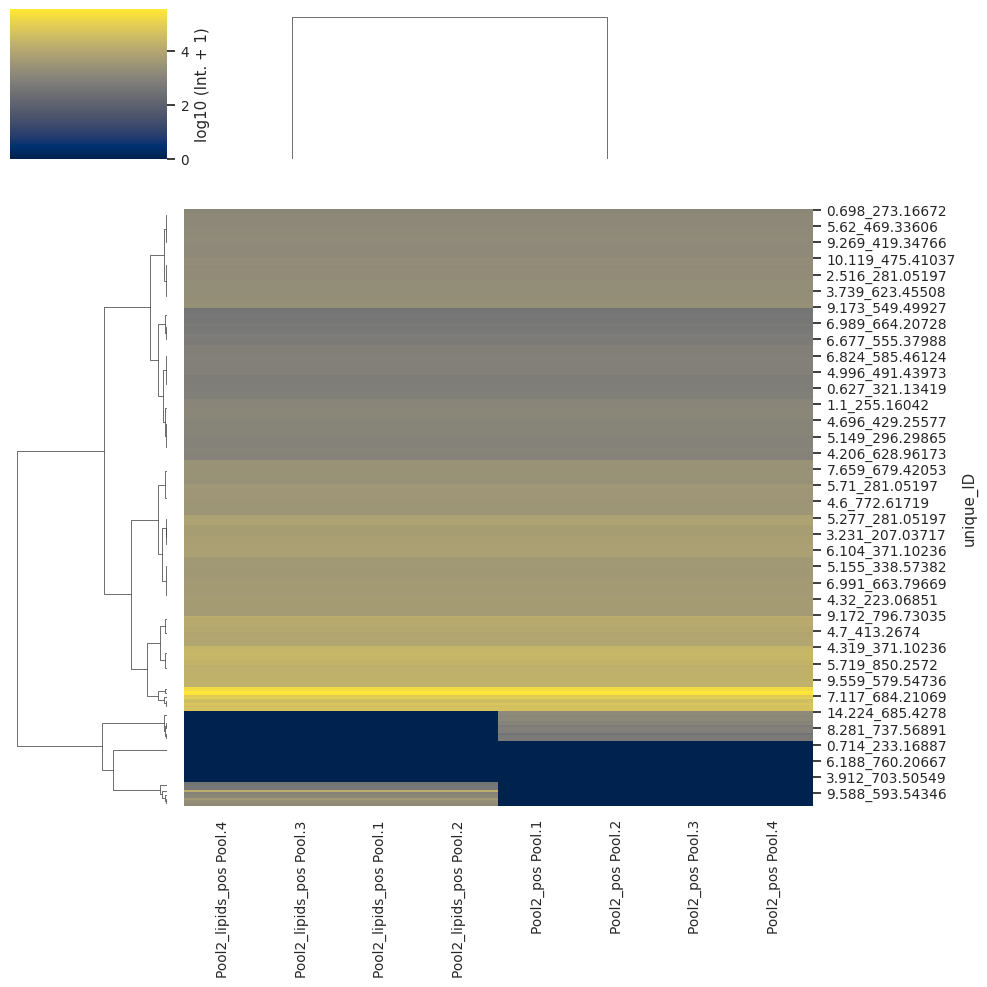

In [14]:
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(log10_pools, 
                   cmap='cividis', 
                   row_cluster=True, col_cluster=True,
                   method=linkage_method, metric=distance_metric, 
                   cbar_kws={'label':'log10 (Int. + 1)'}
                  )
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# 3.2. visualize samples distribution

In [15]:
# remove any feature that does not cross the threshold of 300
print(log10_intensities.shape)

log10_intensities = log10_intensities[log10_intensities.max(axis=1) >= numpy.log10(300 + 1)]

print(log10_intensities.shape)
log10_intensities.head()

(295, 53)
(275, 53)


,008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,008-09 4 CAT,008-10 24,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,,,,,,,,,,,,,,
0.609_305.16281,3.760020,3.567989,4.356094,2.778523,3.557296,2.705529,3.355025,3.411315,0.000000,2.681986,...,0.0,3.778011,3.726447,3.726447,3.726447,3.726447,3.726447,3.726447,3.726447,3.726447
0.611_217.10544,3.291500,3.958263,4.104665,3.203801,3.491627,2.915737,3.744422,3.633099,3.447201,2.899609,...,0.0,3.621431,3.583796,3.583796,3.583796,3.583796,3.583796,3.583796,3.583796,3.583796
0.611_349.19458,3.699146,3.441237,4.196234,0.000000,3.555064,2.613688,3.295763,3.311083,0.000000,2.553089,...,0.0,3.944869,3.643078,3.643078,3.643078,3.643078,3.643078,3.643078,3.643078,3.643078
0.611_393.20673,0.000000,0.000000,0.000000,0.000000,0.000000,2.550203,0.000000,3.304615,0.000000,0.000000,...,0.0,3.981878,3.623400,3.623400,3.623400,3.623400,3.623400,3.623400,3.623400,3.623400
0.612_261.13141,3.608330,3.742001,4.358513,2.935922,3.456193,2.720064,3.441894,3.442981,3.067142,2.752551,...,0.0,3.538408,3.600462,3.600462,3.600462,3.600462,3.600462,3.600462,3.600462,3.600462


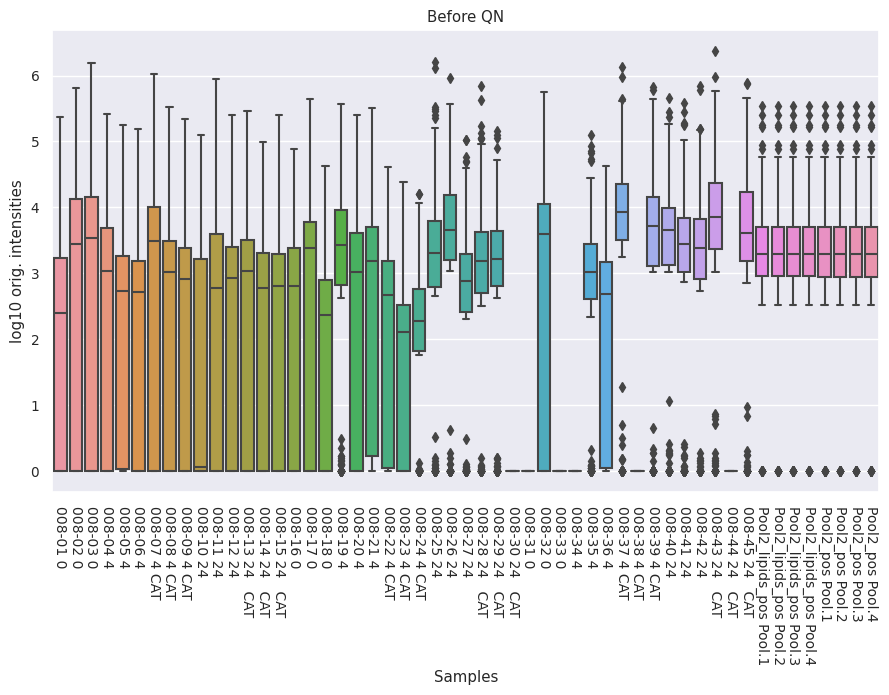

In [16]:
g = seaborn.boxplot(data=log10_intensities)
g.set(ylabel='log10 orig. intensities', xlabel='Samples', title='Before QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=10)
matplotlib.pyplot.show()

In [17]:
numpy.max(log10_intensities['008-30 24   CAT'])

0.0

In [18]:
sdfg

NameError: name 'sdfg' is not defined

## 3.3. visualize samples 

In [ ]:
# PCA before QN
matplotlib.rc_file_defaults()
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

df = log10_intensities.transpose()

x = sklearn.preprocessing.StandardScaler().fit_transform(df)
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print('variance explained', pca.explained_variance_ratio_)

print(principal_df.shape)
principal_df.head()

In [ ]:
for i in range(len(df.index)):
    
    label = df.index[i].split()    
        
    # color for treatment
    if '008' in label[0]:
        if label[-1] == 'CAT':
            plotting_color = 'gold'
        else:
            plotting_color = 'skyblue'
    else:
        plotting_color = 'black'
    
    # marker for time
    if label[1] == '0':
        plotting_marker = '*'
    elif label[1] == '4':
        plotting_marker = 'o'
    elif label[1] == '24':
        plotting_marker = 's'
    else:
        plotting_marker = '.'

    # position
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']

    # add biological replicate
    if '008' in label[0]:
        new_label = label[0].split('-')[0] + '-' + str(int(label[0].split('-')[1]))
        biorep = metadata[metadata['Sample ID'] == new_label]['BioReplicate'].values[0]
        if biorep == 1:
            the_edge_color = 'white'
        elif biorep == 2:
            the_edge_color = 'black'
        else:
            print('Error finding batch number')
            
    # plot the dots
    matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=the_edge_color, marker=plotting_marker, lw=2)

# legend
legend_elements = [
    matplotlib.patches.Patch(facecolor='skyblue', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white'),
    
    matplotlib.lines.Line2D([0], [0], marker='*', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
matplotlib.pyplot.legend(legend_elements, ['control', 'CAT', 'T0', 'T4', 'T24'], ncol=5, fontsize=14)

# close figure
matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1 ({}% var.)'.format(int(pca.explained_variance_ratio_[0]*100)))
matplotlib.pyplot.ylabel('PC2 ({}% var.)'.format(int(pca.explained_variance_ratio_[1]*100)))

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
# 4. identify pattern

In [ ]:
log10_intensities.head()

In [ ]:
metadata

In [ ]:
rules = (metadata['BioReplicate'] == 3) & (metadata['Timepoint'] == 4) & (metadata['µM catech'] == 0)
list(metadata[rules]['Sample ID'].values)

In [ ]:
timepoints = [4, 24]
bioreps = [1, 2, 3]
for timepoint in timepoints:
    for biorep in bioreps:
        
        print('time and biorep', time, biorep)
        
        control_rule = (metadata['BioReplicate'] == biorep) & (metadata['Timepoint'] == timepoint) & (metadata['µM catech'] == 0)
        treatment_rule = (metadata['BioReplicate'] == biorep) & (metadata['Timepoint'] == timepoint) & (metadata['µM catech'] == 5)
        
        control_samples = metadata[control_rule]['Sample ID'].values
        treatment_samples = metadata[treatment_rule]['Sample ID'].values
        
        print('\t', len(control_samples), control_samples)
        print('\t', len(treatment_samples), treatment_samples)
        print()
        
        
        
    